# Set up Environment

In [78]:
import sys
import numpy as np
sys.path.insert(0, "../..")
import scirpy as ir
import scanpy as sc
from glob import glob
import pandas as pd
import tarfile
import anndata
import warnings
from matplotlib import pyplot as plt
from numba import NumbaPerformanceWarning

# ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# suppress "storing XXX as categorical" warnings.
anndata.logging.anndata_logger.setLevel("ERROR")

## Load and merge TCR and RNA data

In [79]:
# Data is loaded raw without any filtering
dataset_names =['289_Pri','290_Pri','295','296_Pri_CD8pos','305_1_Pri','307_Pri','309_Pri','310','314','316',
                '290_LN2','291_Pri','296_Pri_CD8neg','304_Pri','305_2_Pri','307_sLN','309_sLN','313','315']

data_sets = {}
for name in dataset_names:
    rna_file_path = '/data/scRNA/'+'HN'+name+'/filtered_feature_bc_matrix'
    tcr_file_path = '/data/scTCR/'+'VDJ'+name+'/filtered_contig_annotations.csv'
    
    data = sc.read_10x_mtx(rna_file_path,var_names='gene_symbols',cache=True)
    TCR_data = ir.io.read_10x_vdj(tcr_file_path)
    
    ir.pp.merge_with_tcr(data, TCR_data)
    
    data_sets[name] = data
    data_sets[name].var_names_make_unique(join='_')
for name in dataset_names: 
    data_sets[name].obs['sample'] = name
    
# group label
for name in dataset_names:
    if name.find('LN')!=-1:
        data_sets[name].obs['group'] = 'Metastatic'
    else:
        data_sets[name].obs['group'] = 'Primary'  
        
# batch label
batches = {'batch1':['289_Pri','290_Pri','290_LN2','291_Pri'],
           'batch2':['296_Pri_CD8pos','305_1_Pri','296_Pri_CD8neg','304_Pri','305_2_Pri'],
           'batch3':['295','307_Pri','309_Pri','310','314','316','307_sLN','309_sLN','313','315']}
for batch in batches:
    for name in batches[batch]:
        data_sets[name].obs['bat'] = batch

## QC for TCR data by sample

For 289_Pri


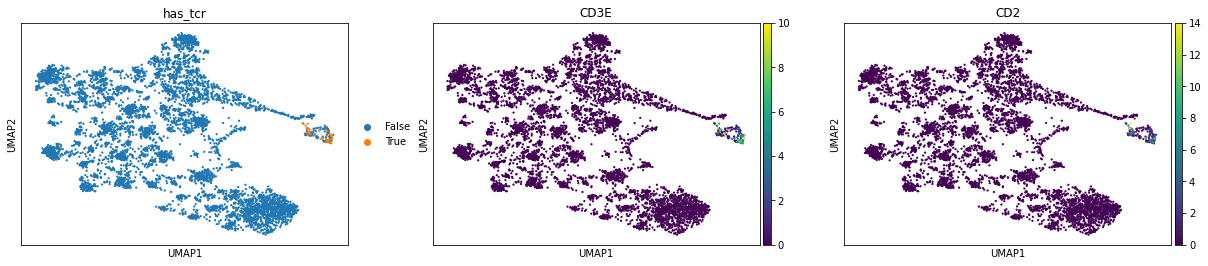

For 290_Pri


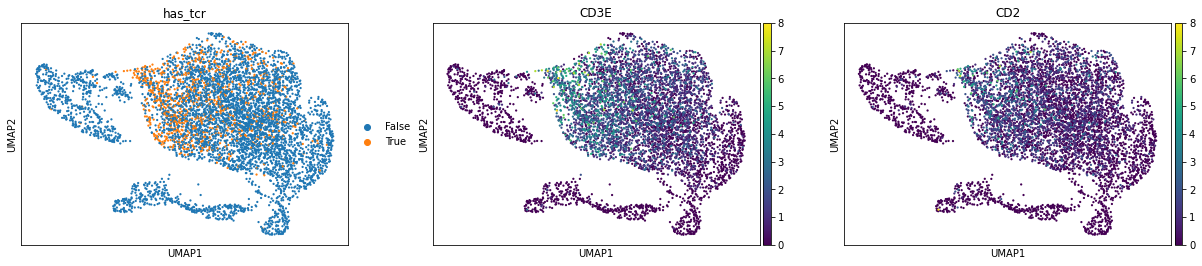

For 295


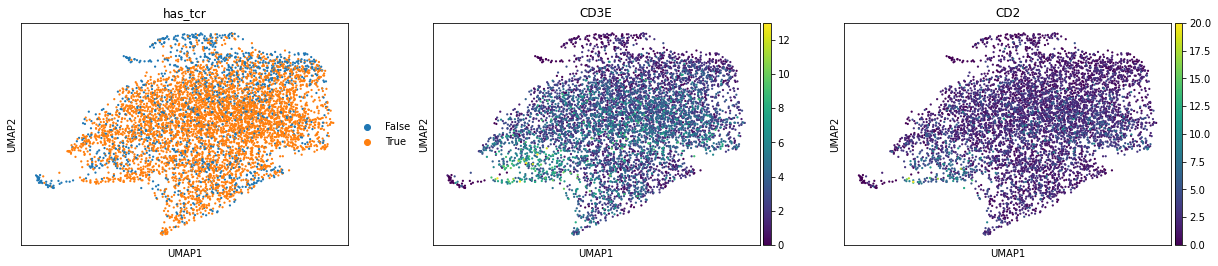

For 296_Pri_CD8pos


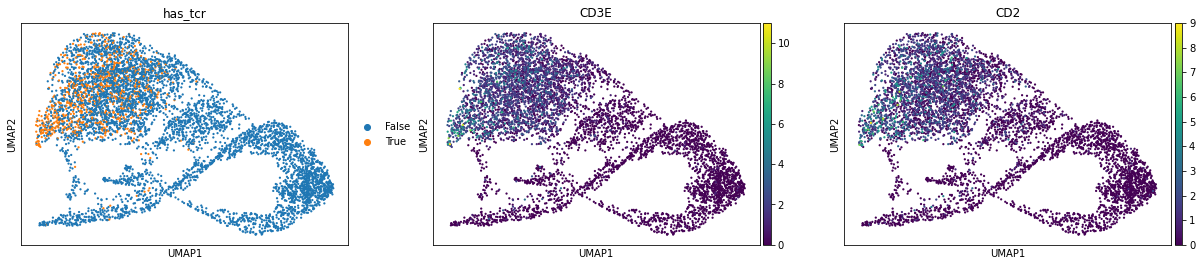

For 305_1_Pri


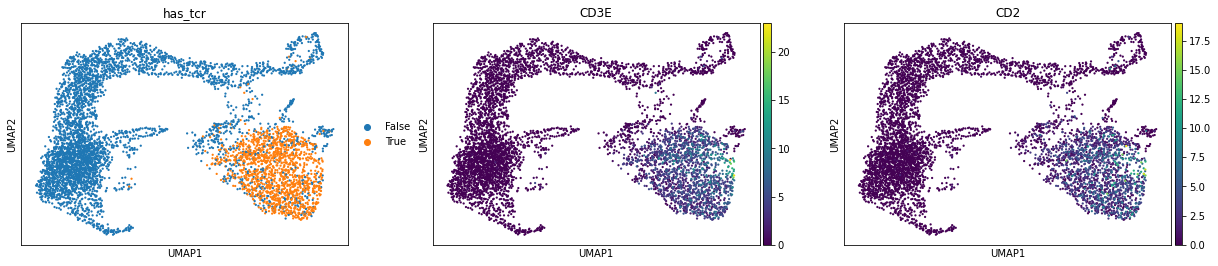

For 307_Pri


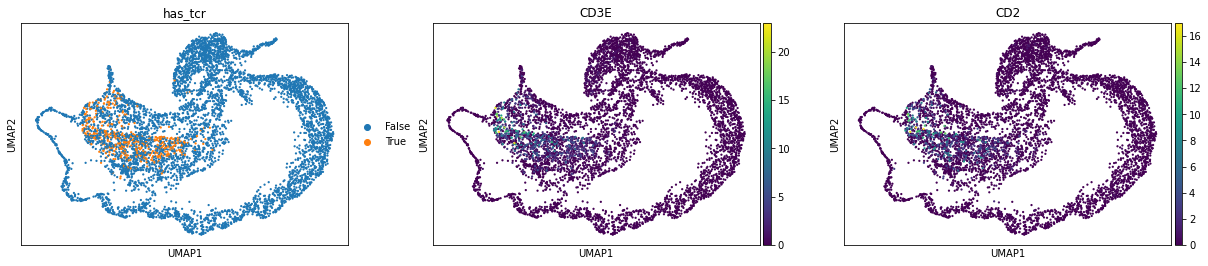

For 309_Pri


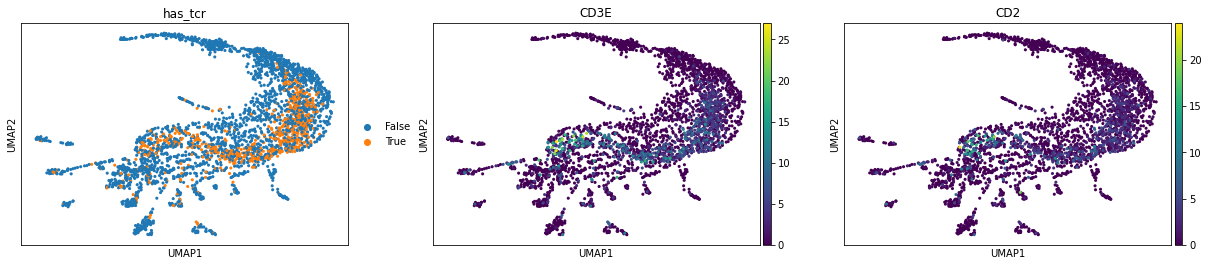

For 310


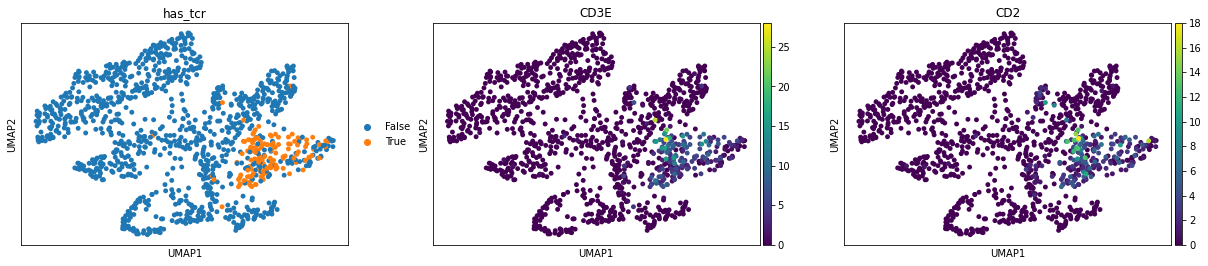

For 314


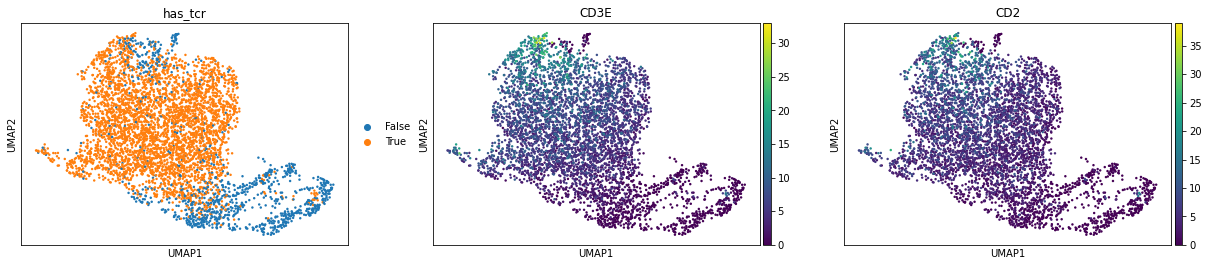

For 316


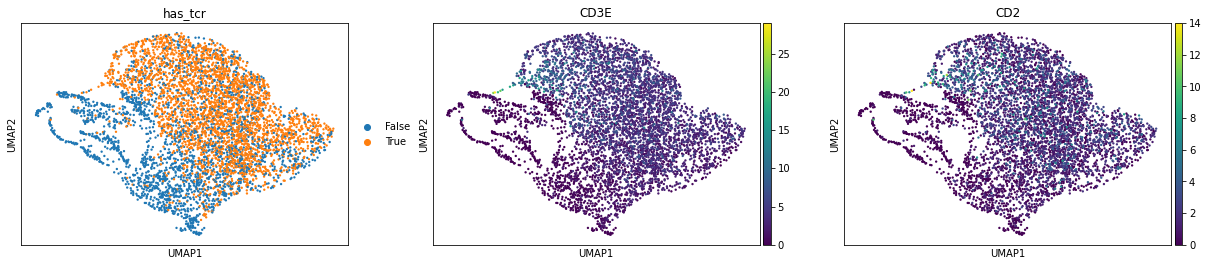

For 290_LN2


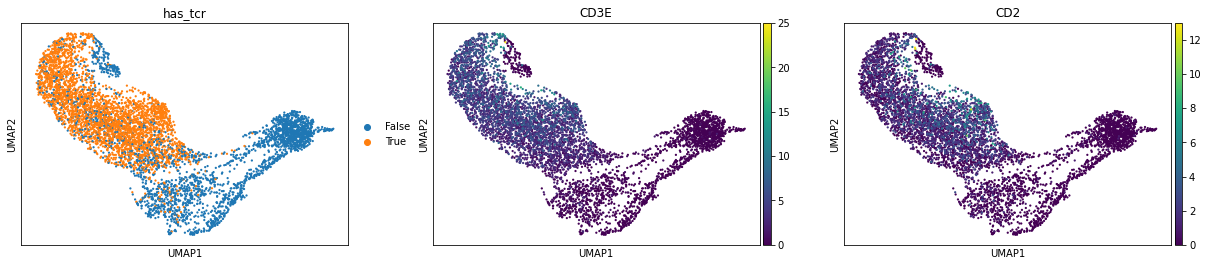

For 291_Pri


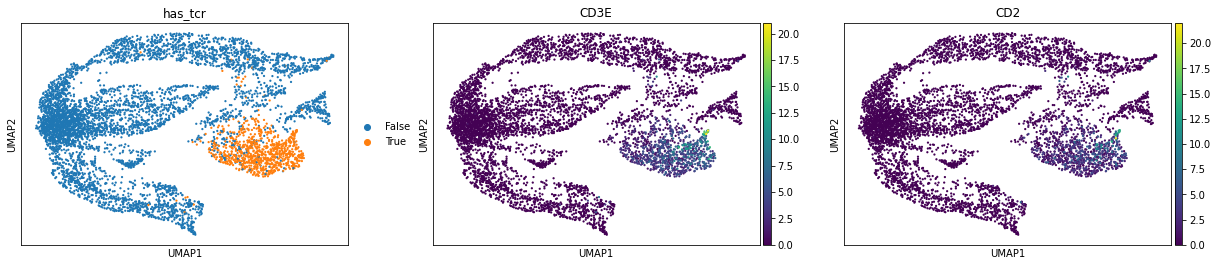

For 296_Pri_CD8neg


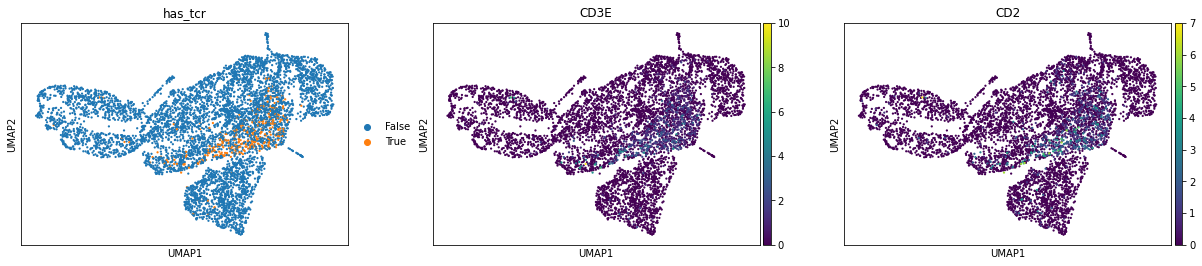

For 304_Pri


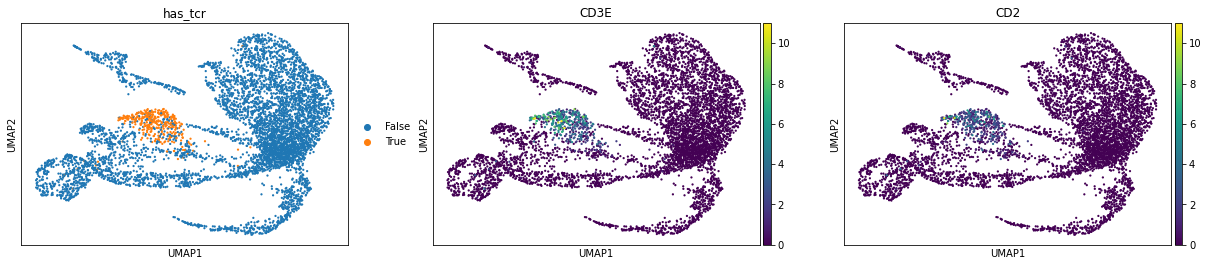

For 305_2_Pri


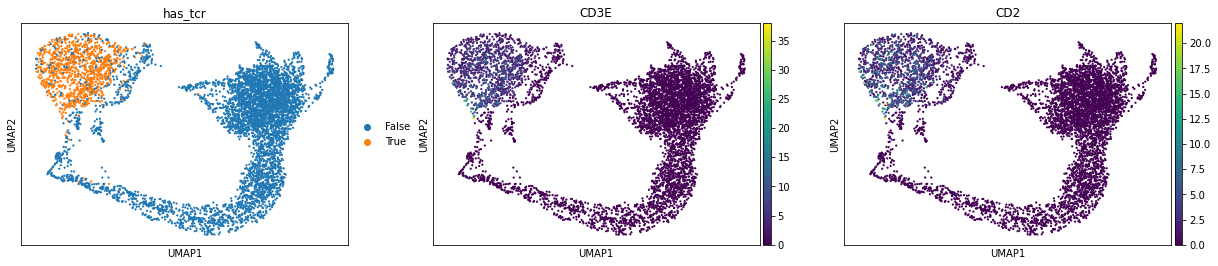

For 307_sLN


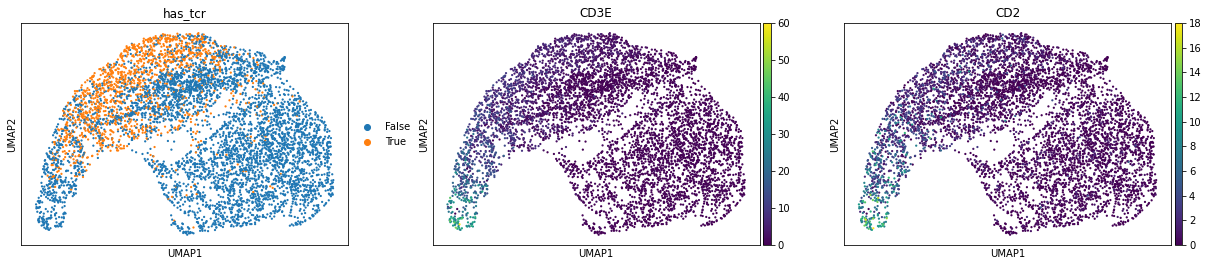

For 309_sLN


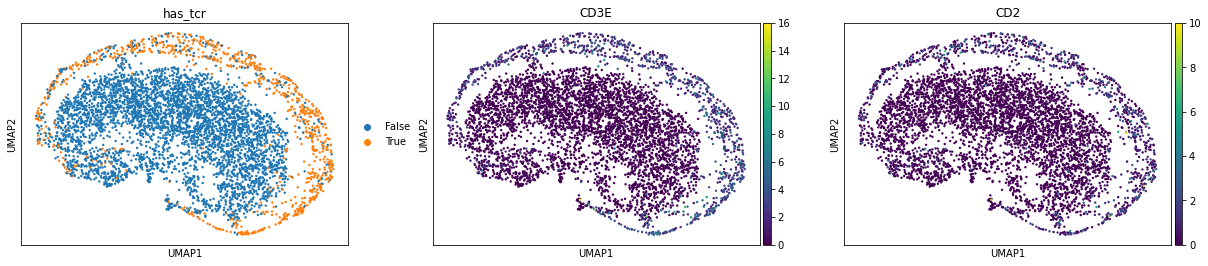

For 313


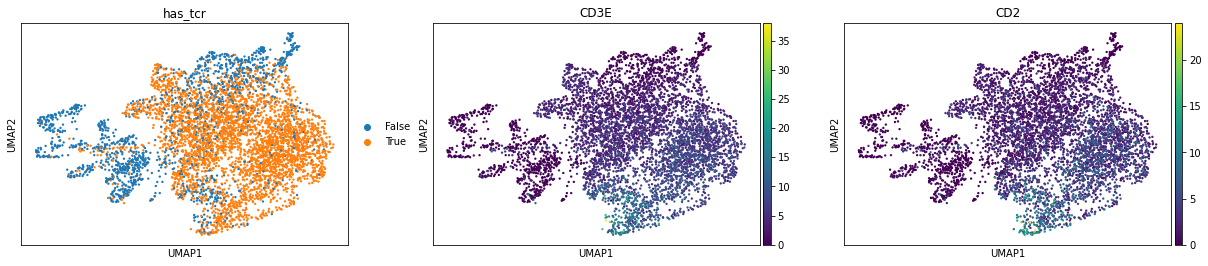

For 315


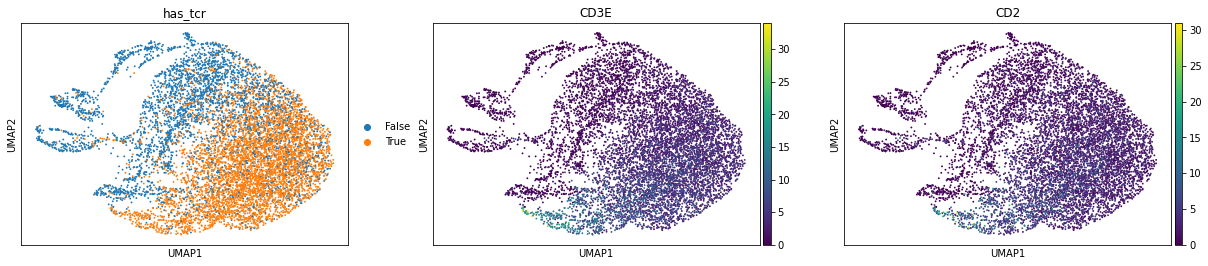

In [80]:
for data_set in data_sets:
    print('For '+data_set)
    sc.pp.pca(data_sets[data_set], svd_solver="arpack")
    sc.pp.neighbors(data_sets[data_set])
    sc.tl.umap(data_sets[data_set])
    sc.pl.umap(data_sets[data_set], color=['has_tcr','CD3E','CD2'])

#### Most TCR data seems fine except for 307_sLN, where there is a chunk of cell (bottom-left) that doesn't have TCR data but show expression of CD3E and CD2 and the cells that have TCR data actually have relatively low expression of CD3E and CD2.

In [81]:
# obtain chain pairing information
for data_set in data_sets:
    ir.tl.chain_pairing(data_sets[data_set])
    

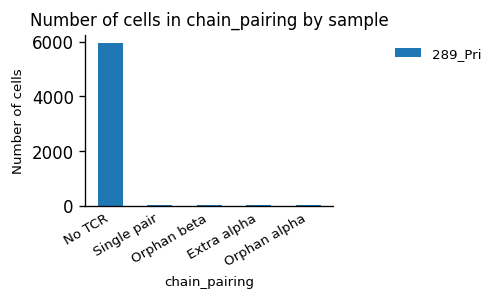

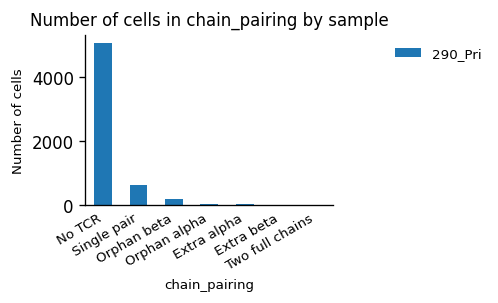

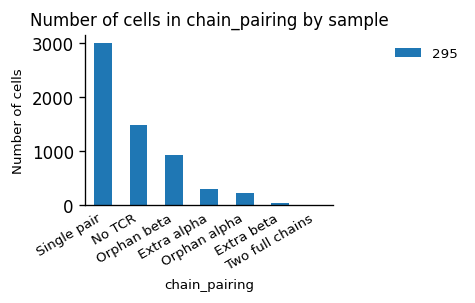

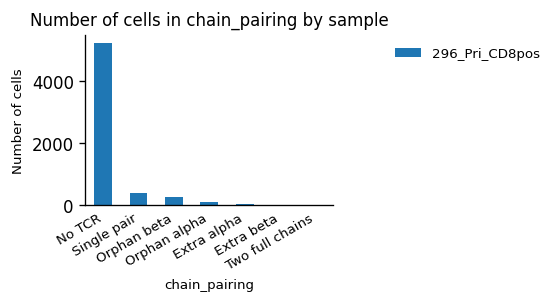

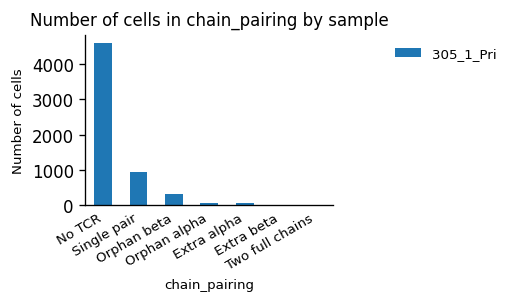

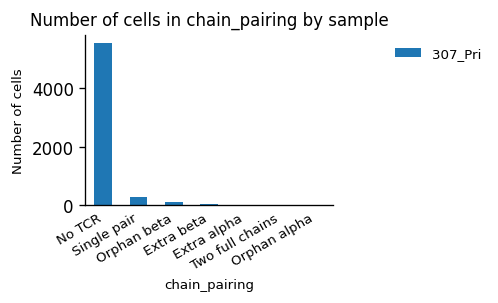

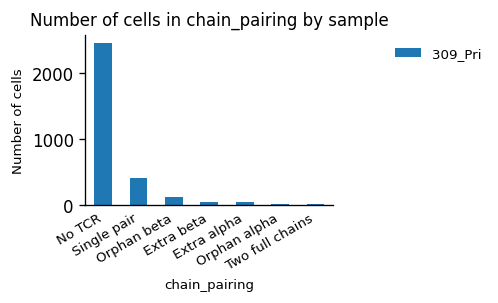

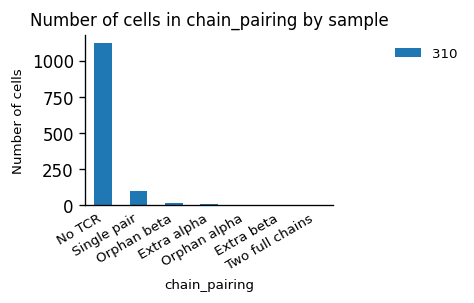

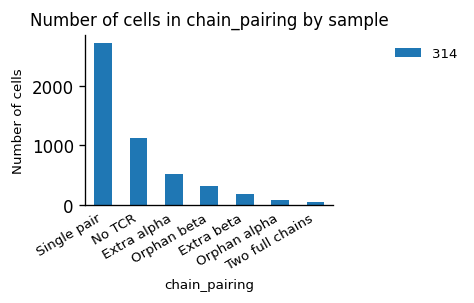

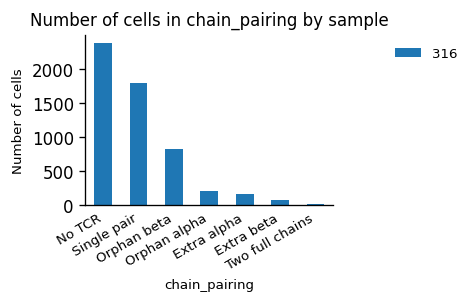

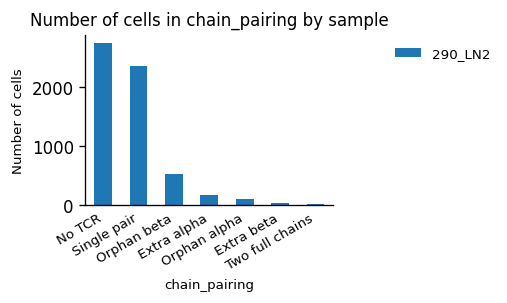

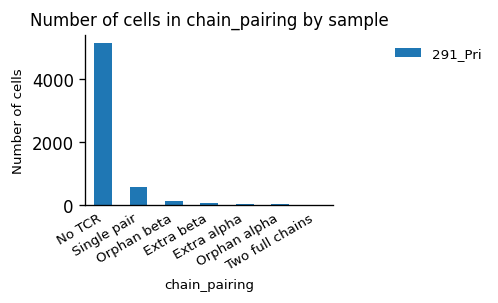

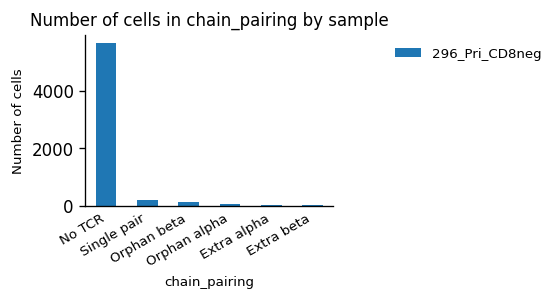

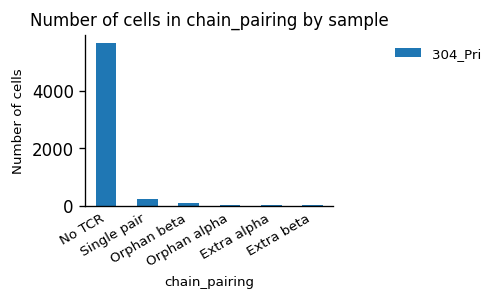

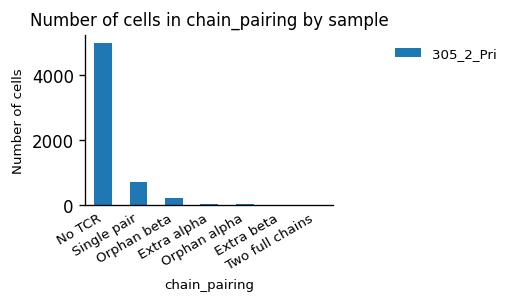

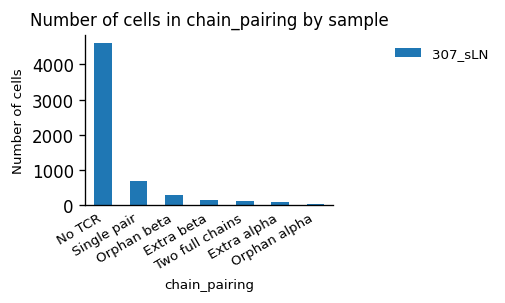

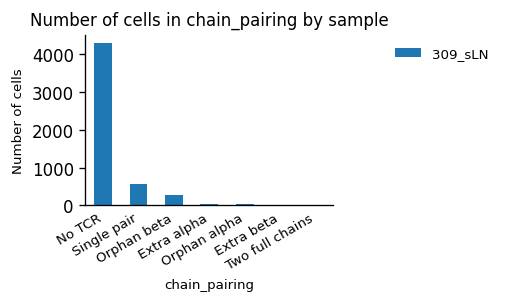

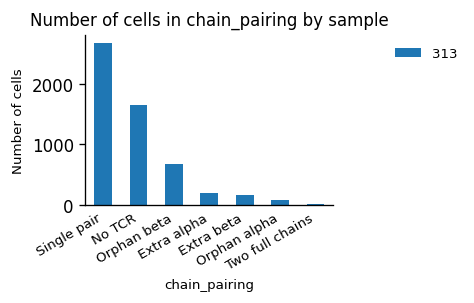

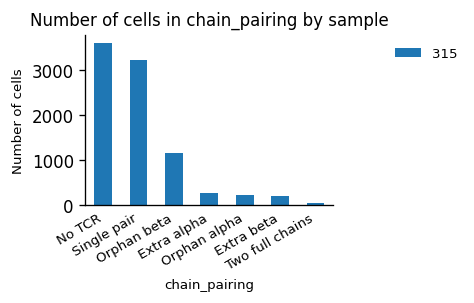

In [82]:
# Visualize chain pairing for each sample
for data_set in data_sets:
    ir.pl.group_abundance(data_sets[data_set], groupby="chain_pairing",target_col='sample')

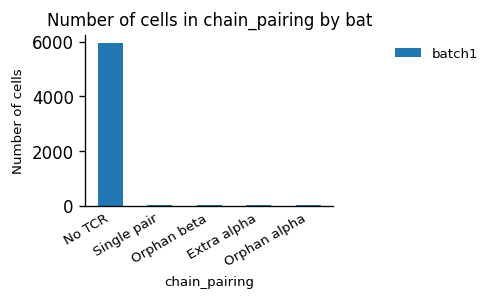

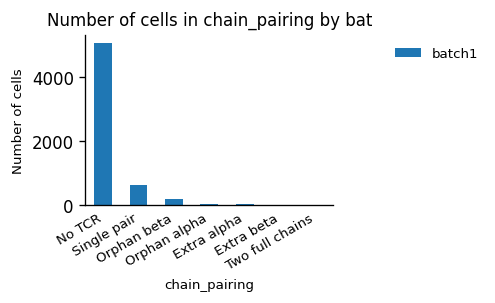

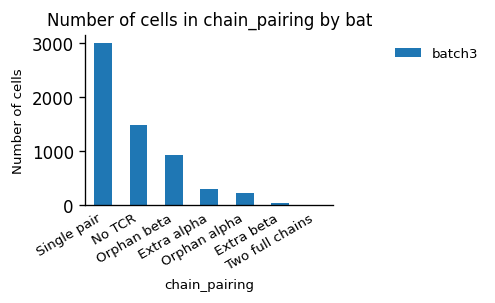

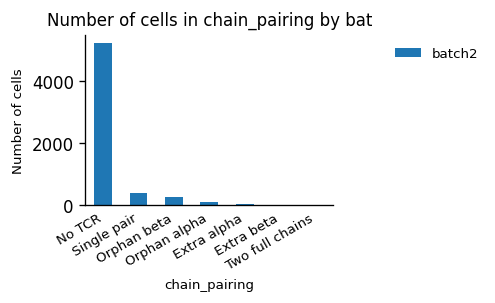

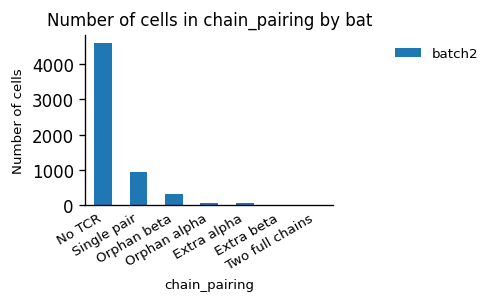

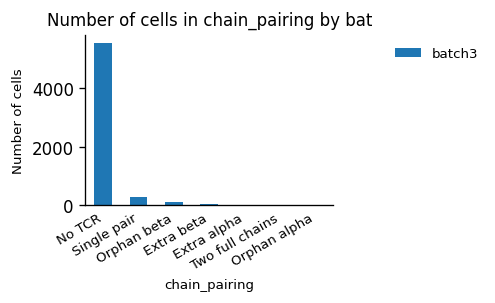

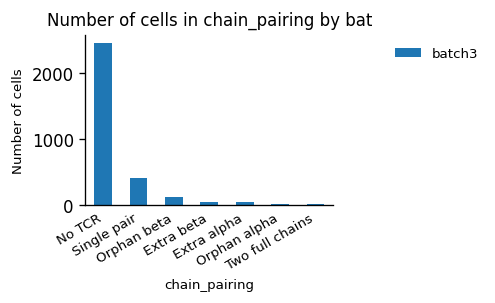

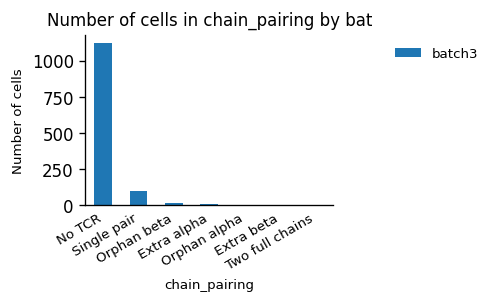

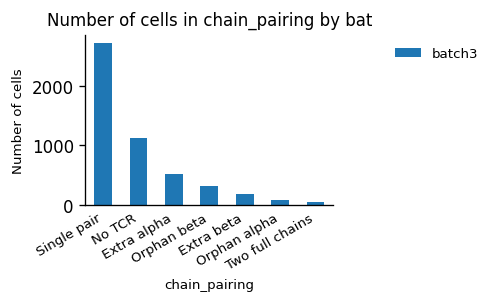

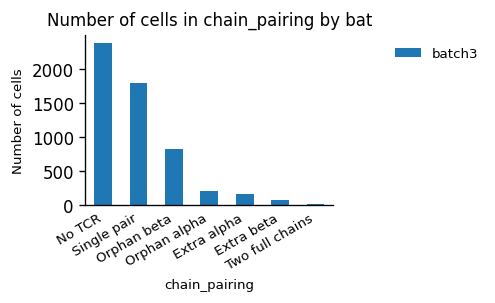

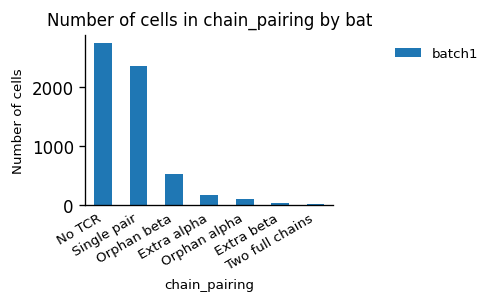

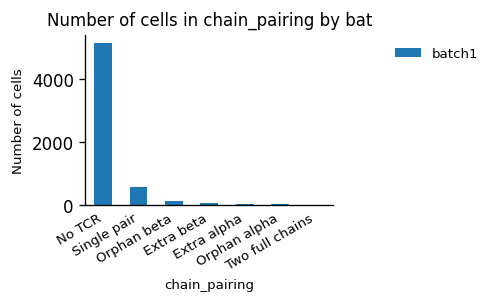

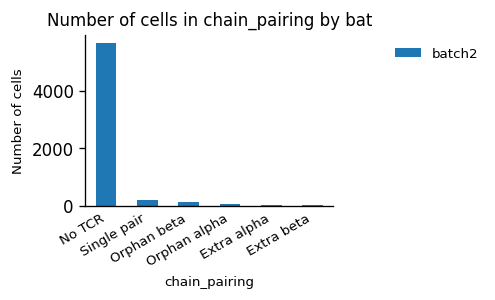

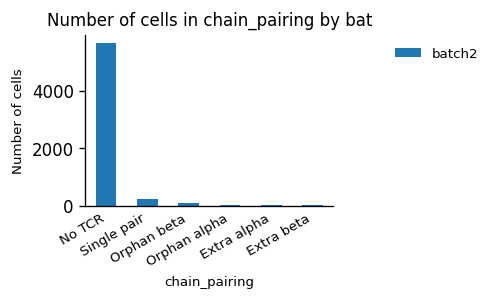

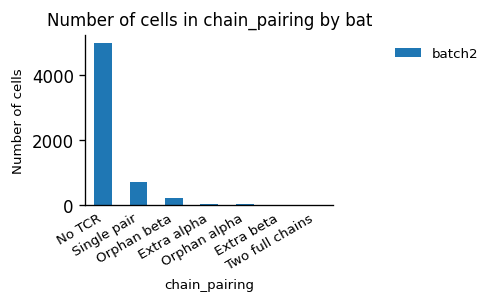

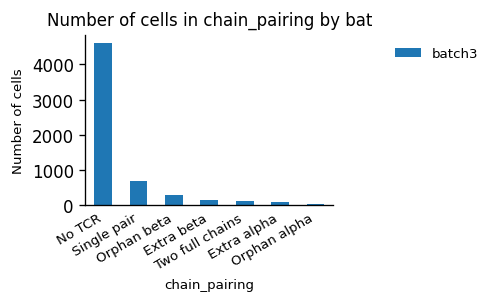

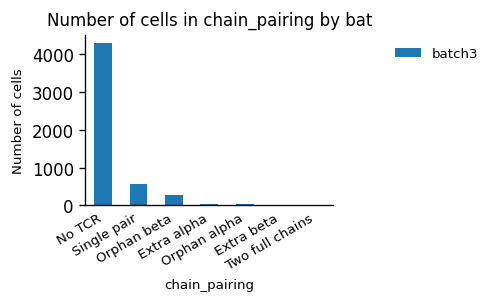

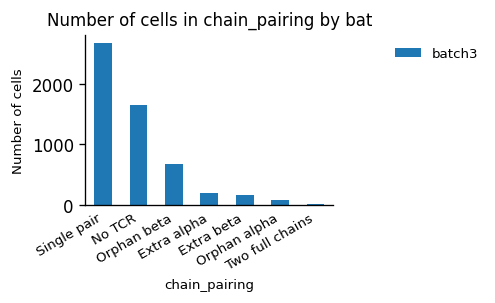

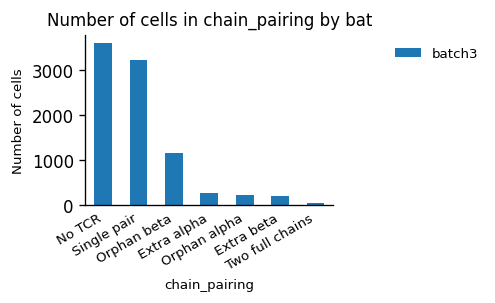

In [83]:
# Visualize chain pairing for each batch
for data_set in data_sets:
    ir.pl.group_abundance(data_sets[data_set], groupby="chain_pairing",target_col='bat')

In [84]:
for data_set in data_sets:
    print("For {}, the fraction of cells with more than one pair of TCRs: {:.3f}".format(
        data_set, np.sum(data_sets[data_set].obs["chain_pairing"].isin(["Extra beta", "Extra alpha", "Two full chains"]))
        /data_sets[data_set].n_obs)
         )

For 289_Pri, the fraction of cells with more than one pair of TCRs: 0.001
For 290_Pri, the fraction of cells with more than one pair of TCRs: 0.008
For 295, the fraction of cells with more than one pair of TCRs: 0.058
For 296_Pri_CD8pos, the fraction of cells with more than one pair of TCRs: 0.008
For 305_1_Pri, the fraction of cells with more than one pair of TCRs: 0.013
For 307_Pri, the fraction of cells with more than one pair of TCRs: 0.012
For 309_Pri, the fraction of cells with more than one pair of TCRs: 0.035
For 310, the fraction of cells with more than one pair of TCRs: 0.010
For 314, the fraction of cells with more than one pair of TCRs: 0.153
For 316, the fraction of cells with more than one pair of TCRs: 0.048
For 290_LN2, the fraction of cells with more than one pair of TCRs: 0.041
For 291_Pri, the fraction of cells with more than one pair of TCRs: 0.018
For 296_Pri_CD8neg, the fraction of cells with more than one pair of TCRs: 0.001
For 304_Pri, the fraction of cells wit

In [85]:
tcr_and_rna_combined = data_sets['289_Pri'].concatenate(data_sets[name] for name in data_sets if name!='289_Pri')

In [86]:
save_file = '/scratch/tcr_and_rna_combined.h5ad'
tcr_and_rna_combined.write_h5ad(save_file)